## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

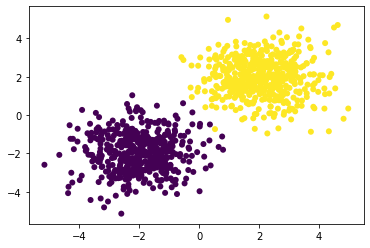

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()
# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

net

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

n_epoch = 20
batch_size = 1000

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

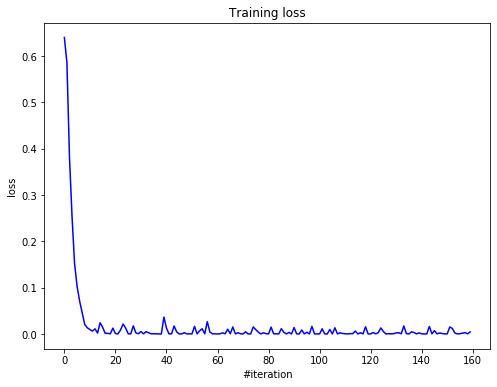

Current loss: 0.004609


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

y_train.shape, y_test.shape, y_val.shape

((50000,), (10000,), (10000,))

One-hot encode the labels first.

In [9]:
# Your code goes here. ################################################

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = encoder.fit_transform(y_val.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

y_train.shape, y_test.shape, y_val.shape

((50000, 10), (10000, 10), (10000, 10))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [10]:
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

criterion = ClassNLLCriterion()

In [11]:
from tqdm.notebook import tqdm

def accur(y_data, y_pred):
    
    res = 0

    for data_list, pred_list in zip(y_data, y_pred):
        data = np.argmax(data_list)
        pred = np.argmax(pred_list)
        if pred == data: 
            res +=1
            
    return res/len(y_data)

def net_tester(net_set, n_epoch):
    losses = {}
    accuracy_train = {}
    accuracy_test = {}
    counter = 0
    
    for num_, net in enumerate(net_set):
        optimizer_state = {}
        loss_history = []
        accuracy_train_history = []
        accuracy_test_history = []
    
        for i in tqdm(range(n_epoch)):
            for X_batch, y_batch in get_batches((X_train, y_train), batch_size):
                net.zeroGradParameters()

                predictions = net.forward(X_batch)
                loss = criterion.forward(predictions, y_batch)

                dp = criterion.backward(predictions, y_batch)
                net.backward(X_batch, dp)
                
                sgd_momentum(
                            net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state)      

                loss_history.append(loss)
                accuracy_train_history.append(accur(net.forward(X_train), y_train))
                accuracy_test_history.append(accur(net.forward(X_val), y_val))
        
        losses.update({num_: loss_history})
        accuracy_train.update({num_: accuracy_train_history})
        accuracy_test.update({num_: accuracy_test_history})
       
    return losses, accuracy_train, accuracy_test

In [12]:
def plot_train_process(loss, accuracy_train, accuracy_test, model_name = ''):
    fig, axes = plt.subplots(1, 2, figsize=(13, 6))

    axes[0].set_title('Training loss')
    axes[0].plot(loss)

    axes[1].set_title('Accuracy')
    axes[1].plot(accuracy_train, label= 'train')
    axes[1].plot(accuracy_test, label = 'test')
    axes[1].legend()
    
#     fig.text('model {}, train acc best {}, test acc best {}'.format(model_name, max(accuracy_train), max(accuracy_test)))
    
    print('model {}, train acc best {}, test acc best {}'.format(model_name, max(accuracy_train), max(accuracy_test)))
    plt.show()

In [14]:
net = Sequential()
net.add(Flatten())
net.add(Linear(784, 50))
net.add(ReLU())
net.add(Linear(50, 10))
net.add(LogSoftMax())

net2 = Sequential()
net2.add(Flatten())
net2.add(Linear(784, 50))
net2.add(BatchNormalization(0.9))
net2.add(ChannelwiseScaling(50))
net2.add(ReLU())
net2.add(Linear(50, 10))
net2.add(LogSoftMax())


net, net2

Flatten
Linear 784 -> 50
BatchNormalization
ChannelwiseScaling
ReLU
Linear 50 -> 10
LogSoftMax

In [15]:
n_epoch = 5
batch_size = 1000


model , train acc best 0.9464, test acc best 0.9488


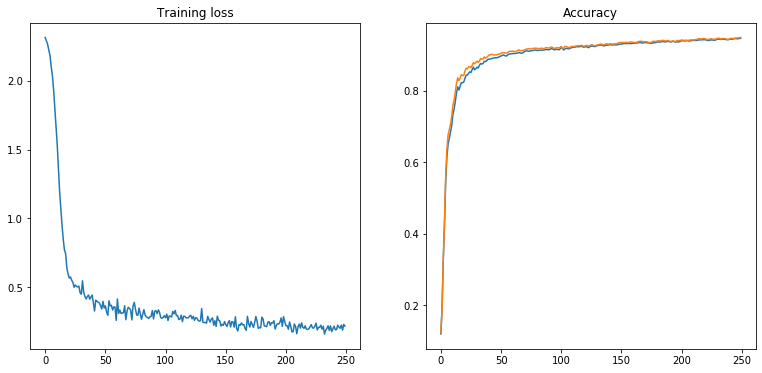

model , train acc best 0.9628, test acc best 0.9601


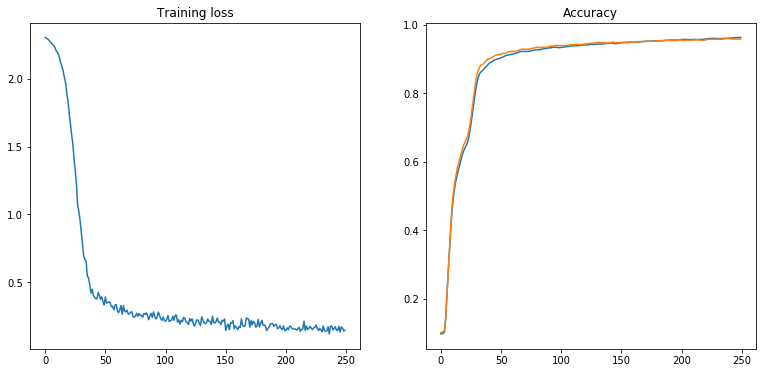

CPU times: user 11min 3s, sys: 5min 17s, total: 16min 20s
Wall time: 9min 34s


In [16]:
%%time

losses, accuracy_train, accuracy_test_history = net_tester((net, net2), n_epoch)
for loss, train_acc, test_acc, name in zip(losses, accuracy_train, accuracy_test_history, ['Relu', 'ReLu with batchnorm']):
    plot_train_process(losses[loss], accuracy_train[train_acc], accuracy_test_history[test_acc], name)

In [17]:
net = Sequential()
net.add(Flatten())
net.add(Linear(784, 50))
net.add(ELU())
net.add(Linear(50, 10))
net.add(LogSoftMax())


net2 = Sequential()
net2.add(Flatten())
net2.add(Linear(784, 50))
net2.add(BatchNormalization(0.9))
net2.add(ChannelwiseScaling(50))
net2.add(ELU())
net2.add(Linear(50, 10))
net2.add(LogSoftMax())



model , train acc best 0.93742, test acc best 0.9423


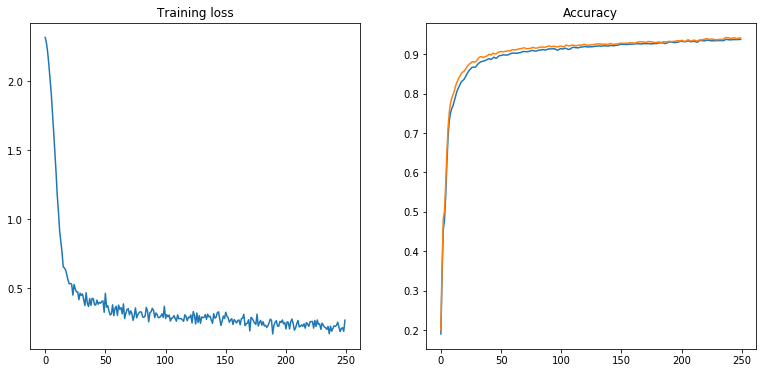

model , train acc best 0.95848, test acc best 0.9563


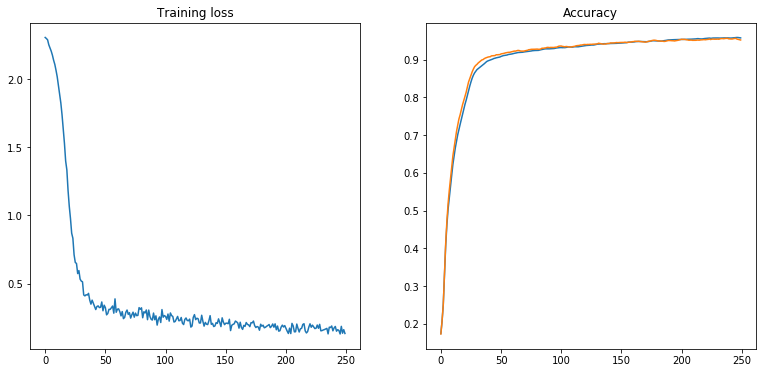

CPU times: user 11min 21s, sys: 5min 56s, total: 17min 18s
Wall time: 9min 56s


In [18]:
%%time


losses, accuracy_train, accuracy_test_history = net_tester((net, net2), n_epoch)
for loss, train_acc, test_acc, name in zip(losses, accuracy_train, accuracy_test_history, ['ELU', 'ELU with batchnorm']):
    plot_train_process(losses[loss], accuracy_train[train_acc], accuracy_test_history[test_acc], name)

In [21]:
net = Sequential()
net.add(Flatten())
net.add(Linear(784, 50))
net.add(LeakyReLU())
net.add(Linear(50, 10))
net.add(LogSoftMax())


net2 = Sequential()
net2.add(Flatten())
net2.add(Linear(784, 50))
net2.add(BatchNormalization(0.9))
net2.add(ChannelwiseScaling(50))
net2.add(LeakyReLU())
net2.add(Linear(50, 10))
net2.add(LogSoftMax())


model , train acc best 0.94228, test acc best 0.9451


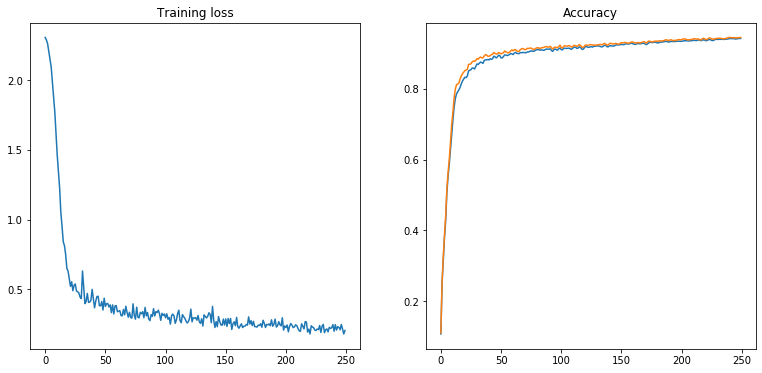

model , train acc best 0.96218, test acc best 0.9587


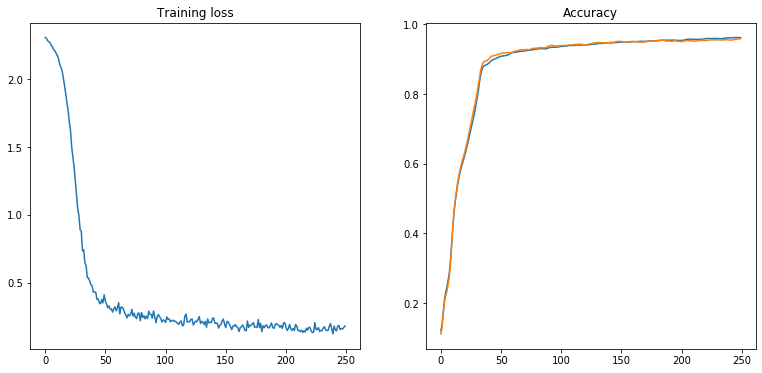

CPU times: user 12min 21s, sys: 4min 36s, total: 16min 57s
Wall time: 8min 37s


In [22]:
%%time


losses, accuracy_train, accuracy_test_history = net_tester((net, net2), n_epoch)
for loss, train_acc, test_acc, name in zip(losses, accuracy_train, accuracy_test_history, ['LeakyReLU', 'LeakyReLU with batchnorm']):
    plot_train_process(losses[loss], accuracy_train[train_acc], accuracy_test_history[test_acc], name)

In [23]:
net = Sequential()
net.add(Flatten())
net.add(Linear(784, 50))
net.add(SoftPlus())
net.add(Linear(50, 10))
net.add(LogSoftMax())

net2 = Sequential()
net2.add(Flatten())
net2.add(Linear(784, 50))
net2.add(BatchNormalization(0.9))
net2.add(ChannelwiseScaling(50))
net2.add(SoftPlus())
net2.add(Linear(50, 10))
net2.add(LogSoftMax())


model , train acc best 0.93248, test acc best 0.9367


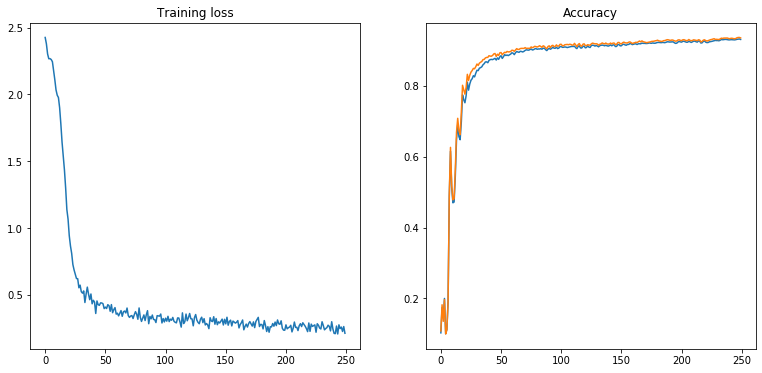

model , train acc best 0.956, test acc best 0.9543


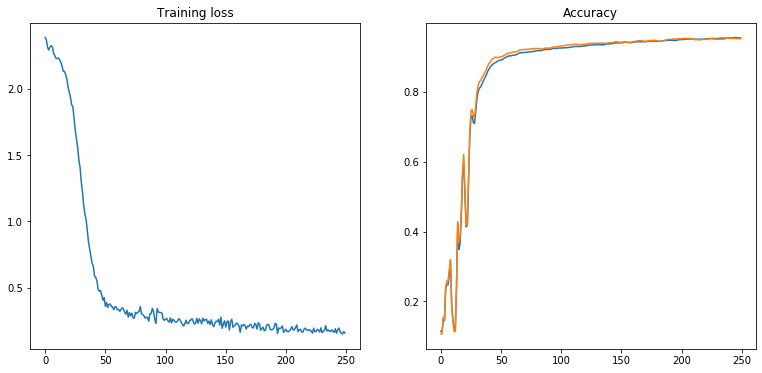

CPU times: user 14min 21s, sys: 4min 15s, total: 18min 36s
Wall time: 8min 13s


In [24]:
%%time


losses, accuracy_train, accuracy_test_history = net_tester((net, net2), n_epoch)
for loss, train_acc, test_acc, name in zip(losses, accuracy_train, accuracy_test_history, ['SoftPlus', 'SoftPlus with batchnorm']):
    plot_train_process(losses[loss], accuracy_train[train_acc], accuracy_test_history[test_acc], name)

**Вывод:** Поигравшись с различными функциями активации, мы поняли что в данном примере наилучшей функцией акивации является `Relu`.

## Adam

In [64]:
def net_adam_tester(net_set, n_epoch):
    losses = {}
    accuracy_train = {}
    accuracy_test = {}
    counter = 0
    
    for num_, net in enumerate(net_set):
        optimizer_state = {}
        loss_history = []
        accuracy_train_history = []
        accuracy_test_history = []
    
        for i in tqdm(range(n_epoch)):
            for X_batch, y_batch in get_batches((X_train, y_train), batch_size):
                net.zeroGradParameters()

                predictions = net.forward(X_batch)
                loss = criterion.forward(predictions, y_batch)

                dp = criterion.backward(predictions, y_batch)
                net.backward(X_batch, dp)
                
                adam_optimizer(
                            net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state)      

                loss_history.append(loss)
                accuracy_train_history.append(accur(net.forward(X_train), y_train))
                accuracy_test_history.append(accur(net.forward(X_val), y_val))
        
        losses.update({num_: loss_history})
        accuracy_train.update({num_: accuracy_train_history})
        accuracy_test.update({num_: accuracy_test_history})
       
    return losses, accuracy_train, accuracy_test

In [65]:
# Looping params
n_epoch = 5
# Optimizer params
optimizer_config = {'learning_rate': 1e-1, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Flatten())
net.add(Linear(784, 50))
net.add(ReLU())
net.add(Linear(50, 10))
net.add(LogSoftMax())

net2 = Sequential()
net2.add(Flatten())
net2.add(Linear(784, 50))
net2.add(BatchNormalization(0.9))
net2.add(ChannelwiseScaling(50))
net2.add(ReLU())
net2.add(Linear(50, 10))
net2.add(LogSoftMax())

print(net, net2)

Flatten
Linear 784 -> 50
ReLU
Linear 50 -> 10
LogSoftMax

Flatten
Linear 784 -> 50
ReLU
Linear 50 -> 10
LogSoftMax
 Flatten
Linear 784 -> 50
BatchNormalization
ChannelwiseScaling
ReLU
Linear 50 -> 10
LogSoftMax




model LeakyReLU, train acc best 0.9439, test acc best 0.9429


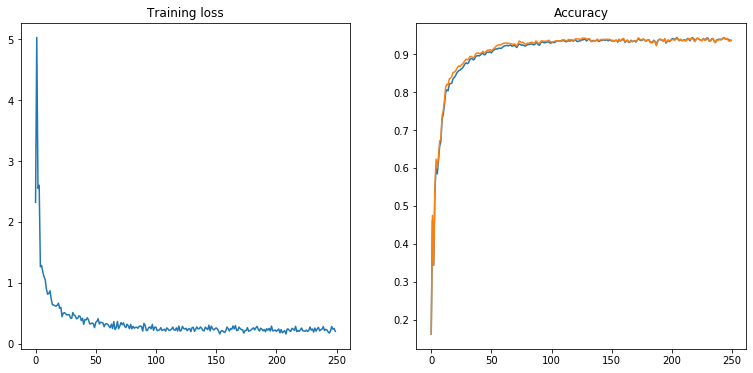

model LeakyReLU with BatchNorm, train acc best 0.98178, test acc best 0.9684


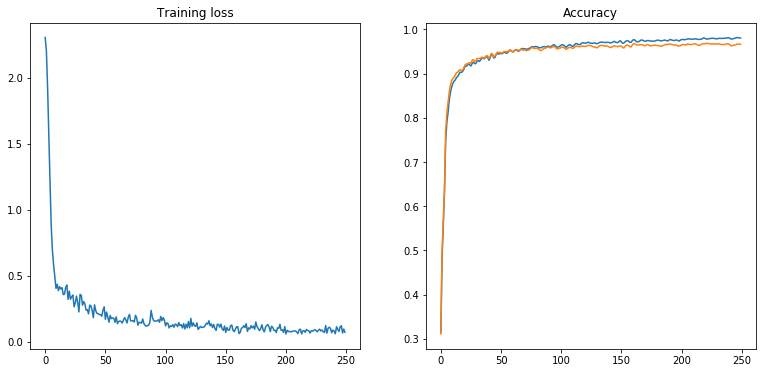

CPU times: user 14min 55s, sys: 3min 20s, total: 18min 16s
Wall time: 6min 46s


In [66]:
%%time

losses, accuracy_train, accuracy_test_history = net_adam_tester((net, net2), n_epoch)
for loss, train_acc, test_acc, name in zip(losses, accuracy_train, accuracy_test_history, ['LeakyReLU', 'LeakyReLU with BatchNorm']):
    plot_train_process(losses[loss], accuracy_train[train_acc], accuracy_test_history[test_acc], name)

In [67]:
data = net.forward(X_test)
pred = y_test
print("Accuracy score:", accur(data, pred))

data2 = net2.forward(X_test)
pred2 = y_test
print("Accuracy score (using batchNorm):", accur(data2, pred2))

Accuracy score: 0.9321
Accuracy score (using batchNorm): 0.9657


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Ответ**
`BatchNormalization` помог достигнуть большой точностью(~1% accuracy), а с помощью метода оптимизации `Adam` мы улучшили качество ~5%.


**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Print here your accuracy on test set. It should be around 90%.

In [80]:
net = Sequential()
net.add(Flatten())
net.add(Linear(784, 50))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(50))
net.add(ReLU())
net.add(Linear(50, 10))
net.add(Dropout(0.1))
net.add(LogSoftMax())


optimizer_config = {'learning_rate' : 1, 'momentum': 0.9}

In [85]:
def best_tester(net_set, n_epoch):
    losses = {}
    accuracy_train = {}
    accuracy_test = {}
    counter = 0
    
    for num_, net in enumerate(net_set):
        optimizer_state = {}
        loss_history = []
        accuracy_train_history = []
        accuracy_test_history = []
    
        for i in tqdm(range(n_epoch)):
            for X_batch, y_batch in get_batches((X_train, y_train), batch_size):
                net.zeroGradParameters()

                predictions = net.forward(X_batch)
                loss = criterion.forward(predictions, y_batch)

                dp = criterion.backward(predictions, y_batch)
                net.backward(X_batch, dp)
                
                optimizer_config['learning_rate'] *= 0.99
                sgd_momentum(
                            net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                            optimizer_state)      

                loss_history.append(loss)
                accuracy_train_history.append(accur(net.forward(X_train), y_train))
                accuracy_test_history.append(accur(net.forward(X_val), y_val))
        
        losses.update({num_: loss_history})
        accuracy_train.update({num_: accuracy_train_history})
        accuracy_test.update({num_: accuracy_test_history})
       
    return losses, accuracy_train, accuracy_test


model best model, train acc best 0.93266, test acc best 0.9303


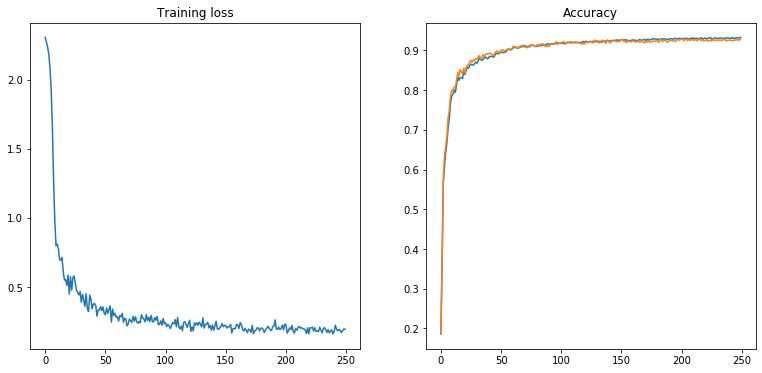

CPU times: user 8min 5s, sys: 1min 58s, total: 10min 4s
Wall time: 3min 43s


In [86]:
%%time

losses, accuracy_train, accuracy_test_history = best_tester((net, ), n_epoch)
for loss, train_acc, test_acc, name in zip(losses, accuracy_train, accuracy_test_history, ['best model']):
    plot_train_process(losses[loss], accuracy_train[train_acc], accuracy_test_history[test_acc], name)

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

Воспользуемся кодом из девятого семинара.

In [105]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

y_train.shape, y_test.shape, y_val.shape

((50000,), (10000,), (10000,))

In [106]:
X_train = X_train.reshape(-1, 28 * 28)
X_val = X_val.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = enc.fit_transform(y_val.reshape(-1, 1)).toarray()

In [141]:
y_train.shape

(50000, 10)

In [148]:
from torch import nn
from torch import optim
import torch

# net = Sequential()
# net.add(Flatten())
# net.add(Linear(784, 50))
# net.add(BatchNormalization(0.9))
# net.add(ChannelwiseScaling(50))
# net.add(ReLU())
# net.add(Linear(50, 10))
# net.add(Dropout(0.1))
# net.add(LogSoftMax())

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 512),
    nn.ReLU(),
    nn.Linear(512, 258),
    nn.BatchNorm1d(258),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(258, 10),
    nn.LogSoftmax(dim=1)
)

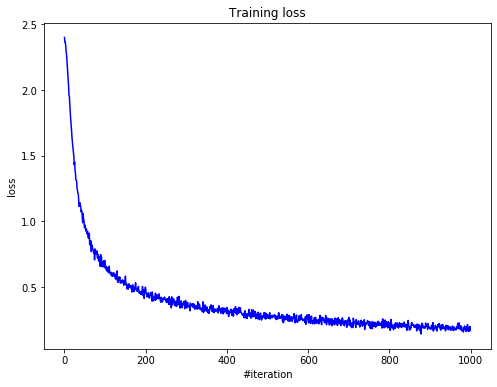

In [149]:
%time
n_epochs = 20
batch_size = 1000

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_history = []
model.train(True)

for i in range(n_epochs):
    for X_batch, y_batch in get_batches((torch.FloatTensor(X_train), torch.Tensor(y_train)), batch_size):
        
        optimizer.zero_grad()
        
        predictions = model.forward(X_batch)
        loss = criterion(predictions, torch.max(y_batch, 1)[1])
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss)
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("iteration num")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

In [152]:
model.eval()
answers, labels = [], []
with torch.no_grad():
    for X_batch, y_batch in get_batches((X_test, torch.Tensor(y_test)), batch_size):
        predictions = model.forward(torch.FloatTensor(X_batch))
        prediction = predictions.argmax(axis=1).reshape(-1, 1)
        answers.append(prediction)
        labels.append(y_batch.reshape(-1, 1))

answers = np.vstack(answers)
labels = np.vstack(labels)

In [153]:
from sklearn.metrics import accuracy_score
print(accuracy_score(answers, labels))

0.9525


**Вывод:** наша реализация даёт точность близую к torch, но скорость работы значительно медленнее